Script to develop flood hazard model based on Elevation, Rainfall and Slope data

In [4]:
import numpy as np
import pandas as pd
import rasterio
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
from rasterio.transform import from_origin
import rasterio
from pyproj import Proj, transform
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

import numpy as np
import rasterio
from scipy.ndimage import zoom



In [ ]:
# Load data
elevationpath ='/Users/tarunluthra/Documents/nycStreamflow/NYCfloodModel/data/elevation/elevation_resampled30m.tif'
slopepath = '/Users/tarunluthra/Documents/nycStreamflow/NYCfloodModel/data/slope/nycslope30.tif'
rainfallpath = '/Users/tarunluthra/Documents/nycStreamflow/NYCfloodModel/data/rainfall/GIOVANNI-g4.timeAvgMap.GPM_3IMERGDF_07_precipitation.20230101-20231231.74W_40N_73W_40N.tif'




In [ ]:
# Load data

slope = rasterio.open('/Users/tarunluthra/Documents/nycStreamflow/NYCfloodModel/data/slope/nycslope30.tif').read(1)
rainfall = rasterio.open('/Users/tarunluthra/Documents/nycStreamflow/NYCfloodModel/data/rainfall/GIOVANNI-g4.timeAvgMap.GPM_3IMERGDF_07_precipitation.20230101-20231231.74W_40N_73W_40N.tif').read(1)

# # Normalize data


In [77]:
rainfall.shape

(4, 6)

Load elevation data

In [8]:
# Open elevation data to get the bounding box and transform
with rasterio.open('/Users/tarunluthra/Documents/nycStreamflow/NYCfloodModel/data/elevation/elevation_resampled30m.tif') as elev_src:
    elevation = elev_src.read(1)
    elev_transform = elev_src.transform
    elev_crs = elev_src.crs
    utm_crs = elev_src.crs  # Get the CRS from the file
    wgs84_crs = rasterio.crs.CRS.from_epsg(4326)  # WGS 84
    elev_bounds = elev_src.bounds
    elev_shape = elevation.shape

print(f"Elevation bounding box: {elev_bounds},{elev_crs},{elev_transform}")

Elevation bounding box: BoundingBox(left=910719.3, bottom=119070.67499999999, right=1068819.3, top=275160.675),EPSG:2263,| 30.00, 0.00, 910719.30|
| 0.00,-30.00, 275160.67|
| 0.00, 0.00, 1.00|


The shape of precipitation data is (4,6) and it needs to be extrapolated and georeferenced to the grid extent of elevation data. 

In [9]:
# Get the CRS coordinates into WGS84

# Define the source and target coordinate systems
# Assuming source CRS is EPSG:2263 (NAD83 / New York Long Island)
src_proj = Proj(init='epsg:2263')
tgt_proj = Proj(init='epsg:4326')  # WGS84

# Coordinates in source CRS bounding coordinates of elevation data
left, bottom = 910719.3, 119070.67499999999
right, top = 1068819.3, 275160.675

# Convert to target CRS (WGS84)
left_lon, bottom_lat = transform(src_proj, tgt_proj, left, bottom)
right_lon, top_lat = transform(src_proj, tgt_proj, right, top)

print(f"Left (Longitude, Latitude): ({left_lon}, {bottom_lat}, {right_lon}, {top_lat})")


Left (Longitude, Latitude): (-74.264365271222, 40.49319158181139, -73.69398743856546, 40.92151985523955)


/opt/homebrew/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/homebrew/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/lf/9_7wh6ps1354b6glt9mst87m0000gn/T/ipykernel_2598/4265302322.py:13: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


In [10]:
# resize the rainfall shape according to elevation

# # Load rainfall data
with rasterio.open(f'{rainfallpath}') as rain_src:
    rainfall = rain_src.read(1)
    rain_transform = rain_src.transform
    rain_crs = rain_src.crs

# Check shapes
print("Original shapes:", elevation.shape, slope.shape, rainfall.shape)

# Determine the zoom factors
zoom_factor_y = elevation.shape[0] / rainfall.shape[0]
zoom_factor_x = elevation.shape[1] / rainfall.shape[1]

# Resize rainfall data
resized_rainfall = zoom(rainfall, (zoom_factor_y, zoom_factor_x), order=1)  # Bilinear interpolation

# Check new shape of resized rainfall
print("Resized rainfall shape:", resized_rainfall.shape)

# Ensure the resized rainfall data matches the elevation and slope data
resized_rainfall = resized_rainfall[:elevation.shape[0], :elevation.shape[1]]

# Combine data into a single array
# data = np.stack((elevation, slope, resized_rainfall), axis=-1)

# Check the combined data shape
print(elevation.shape, slope.shape, resized_rainfall.shape)


Original shapes: (5203, 5270) (5203, 5270) (4, 6)
Resized rainfall shape: (5203, 5270)
(5203, 5270) (5203, 5270) (5203, 5270)


In [9]:
print(elevation.shape, slope.shape, rainfall.shape)

(5203, 5270) (5203, 5270) (4, 6)


In [10]:
rainfall

array([[4.299274 , 4.336096 , 4.388    , 4.396493 , 4.4326572, 4.461315 ],
       [4.282671 , 4.3186436, 4.3487396, 4.368397 , 4.435027 , 4.439082 ],
       [4.2683287, 4.343411 , 4.372219 , 4.4225616, 4.4466577, 4.436082 ],
       [4.2886987, 4.3384657, 4.3324795, 4.3311505, 4.3200135, 4.0568495]],
      dtype=float32)

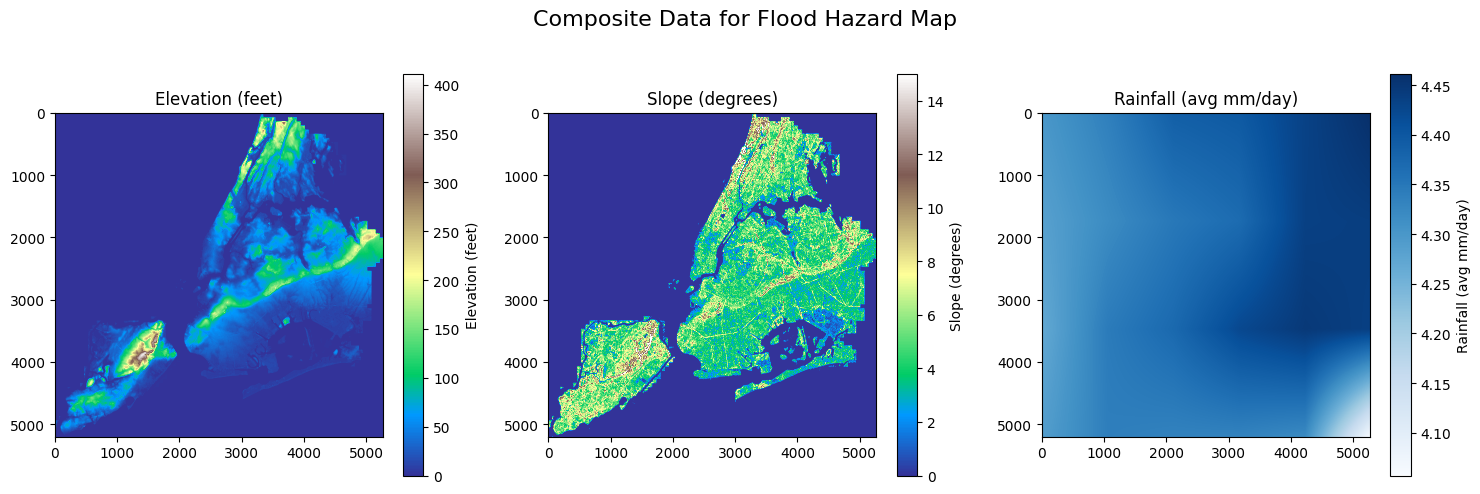

In [13]:

# Assuming elevation, slope, and resized_rainfall are already defined as 2D arrays
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot elevation
elevation_plot = ax[0].imshow(elevation, cmap='terrain')
ax[0].set_title('Elevation (feet)')
cbar = fig.colorbar(elevation_plot, ax=ax[0], orientation='vertical')
cbar.set_label('Elevation (feet)')

# Plot slope, restricted to 0-15 degrees
slope_plot = ax[1].imshow(slope, cmap='terrain', vmin=0, vmax=15)
ax[1].set_title('Slope (degrees)')
cbar = fig.colorbar(slope_plot, ax=ax[1], orientation='vertical')
cbar.set_label('Slope (degrees)')

# Plot rainfall
rainfall_plot = ax[2].imshow(resized_rainfall, cmap='Blues')
ax[2].set_title('Rainfall (avg mm/day)')
cbar = fig.colorbar(rainfall_plot, ax=ax[2], orientation='vertical')
cbar.set_label('Rainfall (avg mm/day)')

# plt.show()
# Add an overall title to the composite data for flood hazard map
fig.suptitle('Composite Data for Flood Hazard Map', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [18]:
# Normalize the data
elevationNorm = (elevation - np.min(elevation)) / (np.max(elevation) - np.min(elevation))
slopeNorm = (slope - np.min(slope)) / (np.max(slope) - np.min(slope))
resized_rainfallNorm = (resized_rainfall - np.min(resized_rainfall)) / (np.max(resized_rainfall) - np.min(resized_rainfall))



In [19]:
# Adjust the elevation data to reflect lower elevations being more prone to flooding
adjusted_elevation = 1 - elevationNorm

In [20]:
# Combine data into a single array
data = np.stack((adjusted_elevation, slopeNorm, resized_rainfallNorm), axis=-1)

In [21]:

# Define the genetic algorithm
def evaluate(individual):
    # Example fitness function; replace with your actual logic
    fitness = np.sum(individual * data)
    return fitness,

# Set up the genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.rand)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=60)

# Run the genetic algorithm
NGEN = 30
for gen in range(NGEN):
    print("gen",gen)
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    fits = map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Extract the best individual (i.e., the best rule set)
best_ind = tools.selBest(population, k=1)[0]
print('Best Individual:', best_ind)


gen 0
gen 1
gen 2
gen 3
gen 4
gen 5
gen 6
gen 7
gen 8
gen 9
gen 10
gen 11
gen 12
gen 13
gen 14
gen 15
gen 16
gen 17
gen 18
gen 19
gen 20
gen 21
gen 22
gen 23
gen 24
gen 25
gen 26
gen 27
gen 28
gen 29
Best Individual: [15.898207124971295, -0.5812825504962125, 7.707135980928483]


In [75]:
# data

In [22]:
# Apply the best individual (rule set) to the data
flood_vulnerability = np.dot(data, np.array(best_ind))

# Normalize the flood vulnerability map for visualization
flood_vulnerability = (flood_vulnerability - np.min(flood_vulnerability)) / (np.max(flood_vulnerability) - np.min(flood_vulnerability))

# Create a DataFrame for Plotly
nyc_shape = flood_vulnerability.shape


Create high threshold flood vulnerability data

In [27]:
high_risk_threshold = np.percentile(flood_vulnerability, 80)  # Top 10% as high risk


In [29]:
# Define a threshold to identify high-risk areas
high_risk_threshold_value = np.percentile(flood_vulnerability, 70)  # Top 10% as high risk

# Create a binary mask for high-risk areas
high_risk_areas = flood_vulnerability >= high_risk_threshold_value

# Convert the boolean mask to uint8
high_risk_areas_uint8 = high_risk_areas.astype(np.uint8)

# Define the output path for the high-risk areas TIFF file
output_path = 'high_risk_areas.tif'

# Write the high-risk areas data to a new TIFF file
with rasterio.open(
    output_path, 'w',
    driver='GTiff',
    height=high_risk_areas_uint8.shape[0],
    width=high_risk_areas_uint8.shape[1],
    count=1,
    dtype=high_risk_areas_uint8.dtype,
    crs=elev_crs,
    transform=elev_transform,
) as dst:
    dst.write(high_risk_areas_uint8, 1)

export the raster flood hazard file

In [27]:
# Define the output path for the flood vulnerability TIFF file
output_path = 'flood_vulnerabilityNewB.tif'

# Write the flood vulnerability data to a new TIFF file
with rasterio.open(
    output_path, 'w',
    driver='GTiff',
    height=flood_vulnerability.shape[0],
    width=flood_vulnerability.shape[1],
    count=1,
    dtype=flood_vulnerability.dtype,
    crs=elev_crs,
    transform=elev_transform,
) as dst:
    dst.write(flood_vulnerability, 1)